# Optimizing a cognitive model with temporal dynamics

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/spa-memory.ipynb)

In the previous examples we have essentially ignored time by defining models that map
inputs to outputs in a single forward pass (e.g., we configured the default synapse to
be `None`). In this example we'll introduce a simple process model of information
retrieval based on [this](https://www.nengo.ai/nengo-spa/examples/question-memory.html)
NengoSPA example. The idea is similar to [this
example](https://www.nengo.ai/nengo-dl/examples/spa-retrieval.html) where we encoded
role/filler information using semantic pointers and then retrieved a cued attribute.
But in this example, rather than presenting the whole trace at once, we will present the
input Role/Filler pairs one at a time and have the network remember them. Once all the
bound pairs have been added to the memory, we can then query the model with a cue to
test retrieval accuracy.

In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
from nengo import spa
import numpy as np
import tensorflow as tf

import nengo_dl

## Optimizing a memory network

First we'll define a function for generating training data.  Note that this function
will produce arrays of shape `(n_inputs, n_steps, dims)`, where `n_steps` will be the
number of time steps in the process we want to model. To start, we'll generate simple
examples in which the input trajectory consists of a single semantic pointer presented
for some number of time steps, and the desired output trajectory involves maintaining a
representation of that semantic pointer for some further number of time steps.

In [2]:
def get_memory_data(
    n_inputs, vec_d, vocab_seed, presentation_time, delay_time, dt=0.001
):
    int_steps = int(presentation_time / dt)
    mem_steps = int(delay_time / dt)
    n_steps = int_steps + mem_steps

    rng = np.random.RandomState(vocab_seed)
    vocab = spa.Vocabulary(dimensions=vec_d, rng=rng, max_similarity=1)

    # initialize arrays for input and output trajectories
    inputs = np.zeros((n_inputs, n_steps, vec_d))
    outputs = np.zeros((n_inputs, n_steps, vec_d))

    # iterate through examples to be generated, fill arrays
    for n in range(n_inputs):
        name = f"SP_{n}"
        vocab.add(name, vocab.create_pointer())

        # create inputs and target memory for first pair
        inputs[n, :int_steps, :] = vocab[name].v
        outputs[n, :, :] = vocab[name].v

    # make scaling ramp for target output trajectories
    ramp = np.asarray([t / int_steps for t in range(int_steps)])
    ramp = np.concatenate((ramp, np.ones(n_steps - int_steps)))
    outputs = outputs * ramp[None, :, None]

    return inputs, outputs, vocab

Our first model will consist of a single input node and single recurrently connected
memory ensemble. The input will present the input semantic pointer for a brief period,
and then the task of the model will be to remember that semantic pointer over time.

In [3]:
seed = 0
t_int = 0.01  # length of time for input presentation
t_mem = 0.04  # length of time for the network to store the input
dims = 32  # dimensionality of semantic pointer vectors
n_neurons = 3 * dims  # number of neurons for memory ensemble
minibatch_size = 32

with nengo.Network(seed=seed) as net:
    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])

    sp_input = nengo.Node(np.zeros(dims))
    memory = nengo.Ensemble(n_neurons, dims)

    tau = 0.01  # synaptic time constant on recurrent connection
    nengo.Connection(sp_input, memory, transform=tau / t_int, synapse=tau)
    nengo.Connection(memory, memory, transform=1, synapse=tau)

    sp_probe = nengo.Probe(sp_input)
    memory_probe = nengo.Probe(memory)

Next, we'll run the model for the specified length of time in order to see how well the
memory works.

In [4]:
# generate test data
test_inputs, test_targets, test_vocab = get_memory_data(
    minibatch_size, dims, seed, t_int, t_mem
)

# run with one example input
with nengo_dl.Simulator(net, seed=seed, minibatch_size=minibatch_size) as sim:
    sim.run(t_int + t_mem, data={sp_input: test_inputs})

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|                         Constructing graph       #                  | 0:00:05

|                         Constructing graph             #            | 0:00:05

|                         Constructing graph              #           | 0:00:05

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (42%)             | ETA: 0:00:00

|                         Constructing graph                #         | 0:00:05

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:05                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|##############Constructing graph: build stage (28%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

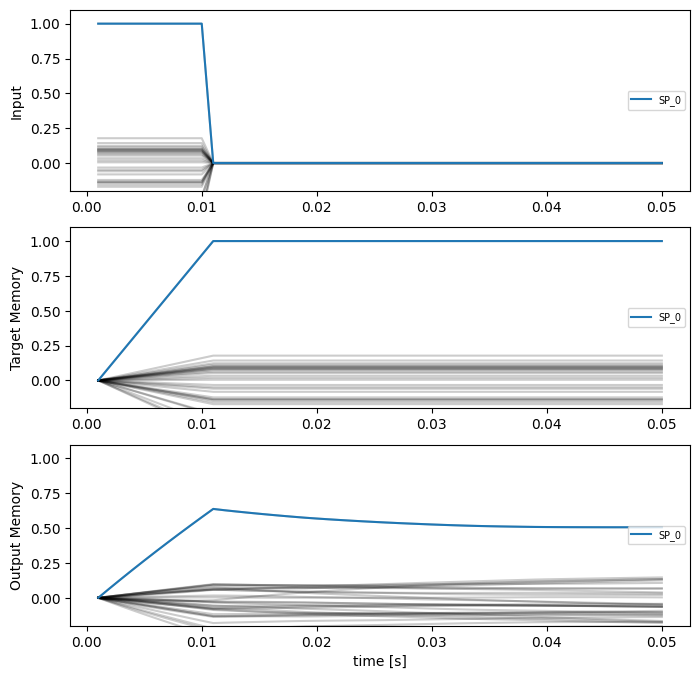

In [5]:
def plot_memory_example(plot_sim, vocab, example_input=0):
    plt.figure(figsize=(8, 8))

    name = f"SP_{example_input}"

    plt.subplot(3, 1, 1)
    plt.plot(
        plot_sim.trange(),
        nengo.spa.similarity(test_inputs[example_input], vocab),
        color="black",
        alpha=0.2,
    )
    plt.plot(
        plot_sim.trange(),
        nengo.spa.similarity(test_inputs[example_input], vocab[name].v),
        label=name,
    )
    plt.legend(fontsize="x-small", loc="right")
    plt.ylim([-0.2, 1.1])
    plt.ylabel("Input")

    plt.subplot(3, 1, 2)
    plt.plot(
        plot_sim.trange(),
        nengo.spa.similarity(test_targets[example_input], vocab),
        color="black",
        alpha=0.2,
    )
    plt.plot(
        plot_sim.trange(),
        nengo.spa.similarity(test_targets[example_input], vocab[name].v),
        label=name,
    )
    plt.legend(fontsize="x-small", loc="right")
    plt.ylim([-0.2, 1.1])
    plt.ylabel("Target Memory")

    plt.subplot(3, 1, 3)
    plt.plot(
        plot_sim.trange(),
        nengo.spa.similarity(plot_sim.data[memory_probe][example_input], vocab),
        color="black",
        alpha=0.2,
    )
    plt.plot(
        plot_sim.trange(),
        nengo.spa.similarity(plot_sim.data[memory_probe][example_input], vocab[name].v),
        label=name,
    )
    plt.legend(fontsize="x-small", loc="right")
    plt.ylim([-0.2, 1.1])
    plt.ylabel("Output Memory")
    plt.xlabel("time [s]")


plot_memory_example(sim, test_vocab)

These plots show the similarity of the input/target/output vectors to all the items in
the vocabulary.  The similarity to the correct vocabulary item is highlighted, and we
can see that while the memory is storing the correct item, that storage is not
particularly stable.

To improve retention we can use NengoDL to fine tune the model parameters. Training on
temporally extended trajectories can be slow, so we'll download pretrained parameters by
default. You can train your own parameters by setting `do_training=True` (allowing you
to vary things like learning rate or the number of training epochs to see the impact of
those hyperparameters).

In [6]:
do_training = False
if do_training:
    train_inputs, train_targets, _ = get_memory_data(4000, dims, seed, t_int, t_mem)

    with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=seed) as sim:
        sim.compile(
            optimizer=tf.optimizers.RMSprop(1e-4), loss={memory_probe: tf.losses.mse}
        )

        print(
            "Test loss before:",
            sim.evaluate({sp_input: test_inputs}, {memory_probe: test_targets})["loss"],
        )

        sim.fit({sp_input: train_inputs}, {memory_probe: train_targets}, epochs=100)

        print(
            "Test loss after:",
            sim.evaluate({sp_input: test_inputs}, {memory_probe: test_targets})["loss"],
        )

        sim.save_params("./mem_params")
else:
    # download pretrained parameters
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1hwMoJ4RCm8-f4yN0kxdzl0ELvDqHuEUC",
        "mem_params.npz",
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (42%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (42%)             | ETA: 0:00:00

| #                           Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                          Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

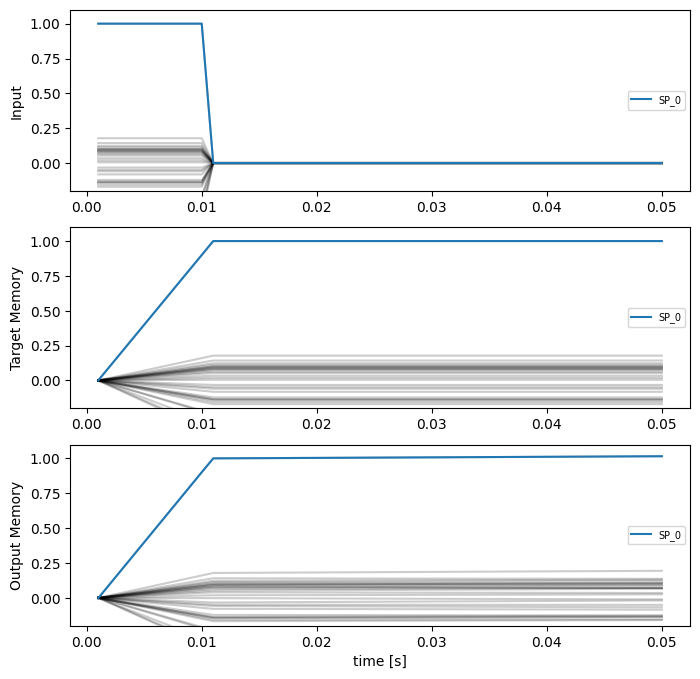

In [7]:
with nengo_dl.Simulator(net, seed=seed, minibatch_size=minibatch_size) as sim:
    sim.load_params("./mem_params")
    sim.run(t_int + t_mem, data={sp_input: test_inputs})

plot_memory_example(sim, test_vocab)

We can see that the training procedure significantly improves the stability of the
memory.

## Adding memory to the cognitive model

Now we will return to the cued role/filler retrieval task from [this
example](https://www.nengo.ai/nengo-dl/examples/spa-retrieval.html), and we will modify
that task to include a memory aspect. Rather than presenting the complete trace as input
all at once, we will present each $ROLE$/$FILLER$ pair one at a time.  The task of the
network will be to bind each individual pair together, add them together to generate the
full trace, store that trace in memory, and then when given one of the Roles as a cue,
output the corresponding Filler.  For example, one pass through the task would consist
of the following phases:

| phase | role input | filler input | cue       | target output |
|-------|------------|--------------|-----------|---------------|
| 1     | $ROLE_0$   | $FILLER_0$   |     -     |       -       |
| 2     | $ROLE_1$   | $FILLER_1$   |     -     |       -       |
| ...   |     ...    |      ...     |    ...    |      ...      |
| $n$   | $ROLE_n$   | $FILLER_n$   |     -     |       -       |
| $n+1$ |      -     |       -      | $ROLE_x$  | $FILLER_x$    |

First we will create a function to generate the input/target data for this task.

In [8]:
def get_binding_data(
    n_items, pairs_per_item, vec_d, rng_seed, presentation_time, delay_time, dt=0.001
):
    int_steps = int(presentation_time / dt)
    mem_steps = int(delay_time / dt)
    n_steps = int_steps * pairs_per_item + mem_steps

    rng = np.random.RandomState(rng_seed)
    vocab = spa.Vocabulary(dimensions=vec_d, rng=rng, max_similarity=1)

    # initialize arrays for input and output trajectories
    roles = np.zeros((n_items, n_steps, vec_d))
    fills = np.zeros((n_items, n_steps, vec_d))
    cues = np.zeros((n_items, n_steps, vec_d))
    binding = np.zeros((n_items, n_steps, vec_d))
    mem = np.zeros((n_items, n_steps, vec_d))
    output = np.zeros((n_items, n_steps, vec_d))

    # iterate through examples to be generated, fill arrays
    for n in range(n_items):
        role_names = [f"ROLE_{n}_{i}" for i in range(pairs_per_item)]
        filler_names = [f"FILLER_{n}_{i}" for i in range(pairs_per_item)]

        # each role/filler pair is presented for presentation_time seconds
        for i in range(pairs_per_item):
            roles[n, i * int_steps : (i + 1) * int_steps] = vocab.parse(role_names[i]).v
            fills[n, i * int_steps : (i + 1) * int_steps] = vocab.parse(
                filler_names[i]
            ).v
            binding[n, i * int_steps : (i + 1) * int_steps] = vocab.parse(
                f"{role_names[i]}*{filler_names[i]}"
            ).v

        # randomly select a cue
        cue_idx = rng.randint(pairs_per_item)

        # cue is presented during the memorization period
        cues[n, -mem_steps:, :] = vocab[role_names[cue_idx]].v

        # the goal is to output the associated filler during the
        # memorization phase
        # note: we use nan for the target prior to the memorization
        # phase, to indicate that it doesn't matter what the network
        # output is during that phase
        output[n, -mem_steps:, :] = vocab[filler_names[cue_idx]].v
        output[n, :-mem_steps, :] = np.nan

    mem[...] = np.cumsum(binding, axis=1) * dt / presentation_time

    return roles, fills, cues, binding, mem, output, vocab

In this more complicated model we'll add two circular convolution network to our
previous memory model, one to convolve the role/filler inputs and one to deconvolve the
cued answer from the memory trace.

In [9]:
seed = 0
t_int = 0.01  # length of time to present each input pair
t_mem = 0.03  # length of memorization period
n_pairs = 2  # number of role/filler pairs in each input
t_run = n_pairs * t_int + t_mem  # total task time
dims = 64  # dimensionality of semantic pointer vectors
neurons_per_dim = 3
minibatch_size = 64

with nengo.Network(seed=seed) as net:
    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    role_inp = nengo.Node(np.zeros(dims))
    fill_inp = nengo.Node(np.zeros(dims))
    cue_inp = nengo.Node(np.zeros(dims))

    # circular convolution network to combine roles/fillers
    cconv = nengo.networks.CircularConvolution(neurons_per_dim, dims)
    nengo.Connection(role_inp, cconv.input_a)
    nengo.Connection(fill_inp, cconv.input_b)

    # memory network to store the role/filler pairs
    memory = nengo.Ensemble(neurons_per_dim * dims, dims)
    tau = 0.01
    nengo.Connection(cconv.output, memory, transform=tau / t_int, synapse=tau)
    nengo.Connection(memory, memory, transform=1, synapse=tau)

    # another circular convolution network to extract the cued filler
    ccorr = nengo.networks.CircularConvolution(neurons_per_dim, dims, invert_b=True)
    nengo.Connection(memory, ccorr.input_a)
    nengo.Connection(cue_inp, ccorr.input_b)

    conv_probe = nengo.Probe(cconv.output, label="conv_probe")
    memory_probe = nengo.Probe(memory, label="memory_probe")
    output_probe = nengo.Probe(ccorr.output, label="output_probe")

We will use the same metric as in the previous [retrieval
example](https://www.nengo.ai/nengo-dl/examples/spa-retrieval.html) in order to assess
the accuracy of the system.  That is, we will say that the network has successfully
retrieved the cued value if the output is more similar to the correct answer than to any
other items in the vocabulary.

In [10]:
def accuracy(output, vocab, targets, t_step=-1):
    # provide the probed output data, the vocab,
    # the target vectors, and the time step at which to evaluate

    # get output at the given time step
    output = output[:, t_step, :]

    # compute similarity between each output and vocab item
    sims = np.dot(vocab.vectors, output.T)
    idxs = np.argmax(sims, axis=0)

    # check that the output is most similar to the target
    acc = np.mean(np.all(vocab.vectors[idxs] == targets[:, -1], axis=1))
    return acc

In [11]:
# generate test data
test_roles, test_fills, test_cues, _, _, test_targets, test_vocab = get_binding_data(
    minibatch_size, n_pairs, dims, seed + 1, t_int, t_mem
)
test_inputs = {role_inp: test_roles, fill_inp: test_fills, cue_inp: test_cues}

with nengo_dl.Simulator(net, seed=seed, minibatch_size=minibatch_size) as sim:
    sim.run(t_run, data=test_inputs)

print("Retrieval accuracy:", accuracy(sim.data[output_probe], test_vocab, test_targets))

|                     Building network (0%)                    | ETA:  --:--:--

|                      Building network (1%)                     | ETA: 0:00:08

|#                     Building network (2%)                     | ETA: 0:00:07

|#                     Building network (2%)                     | ETA: 0:00:06

|##                    Building network (3%)                     | ETA: 0:00:06

|##                    Building network (4%)                     | ETA: 0:00:06

|###                   Building network (5%)                     | ETA: 0:00:06

|####                  Building network (6%)                     | ETA: 0:00:06

|#######              Building network (11%)                     | ETA: 0:00:03

|#########            Building network (14%)                     | ETA: 0:00:02

|###########          Building network (17%)                     | ETA: 0:00:02

|############         Building network (19%)                     | ETA: 0:00:02

|############         Building network (20%)                     | ETA: 0:00:02

|#############        Building network (21%)                     | ETA: 0:00:02

|##############       Building network (22%)                     | ETA: 0:00:02

|##############       Building network (23%)                     | ETA: 0:00:02

|###############      Building network (23%)                     | ETA: 0:00:02

|###############      Building network (24%)                     | ETA: 0:00:02

|################     Building network (25%)                     | ETA: 0:00:02

|#################    Building network (26%)                     | ETA: 0:00:02

|#################    Building network (27%)                     | ETA: 0:00:02

|##################   Building network (28%)                     | ETA: 0:00:02

|##################   Building network (29%)                     | ETA: 0:00:02

|###################  Building network (29%)                     | ETA: 0:00:02

|###################  Building network (30%)                     | ETA: 0:00:02

|#####################Building network (36%)                     | ETA: 0:00:02

|#####################Building network (39%)                     | ETA: 0:00:02

|#####################Building network (41%)                     | ETA: 0:00:01

|#####################Building network (43%)                     | ETA: 0:00:01

|#####################Building network (44%)                     | ETA: 0:00:01

|#####################Building network (45%)                     | ETA: 0:00:01

|#####################Building network (46%)                     | ETA: 0:00:01

|#####################Building network (47%)                     | ETA: 0:00:01

|#####################Building network (48%)                     | ETA: 0:00:01

|#####################Building network (49%)                     | ETA: 0:00:01

|#####################Building network (50%)                     | ETA: 0:00:01

|#####################Building network (51%)                     | ETA: 0:00:01

|#####################Building network (52%)                     | ETA: 0:00:01

|#####################Building network (53%)                     | ETA: 0:00:01

|#####################Building network (54%)                     | ETA: 0:00:01

|#####################Building network (55%)                     | ETA: 0:00:01

|#####################Building network (56%)                     | ETA: 0:00:01

|#####################Building network (62%)                     | ETA: 0:00:01

|#####################Building network (64%)                     | ETA: 0:00:01

|#####################Building network (67%)                     | ETA: 0:00:01

|#####################Building network (68%)#                    | ETA: 0:00:01

|#####################Building network (69%)#                    | ETA: 0:00:01

|#####################Building network (70%)##                   | ETA: 0:00:01

|#####################Building network (71%)##                   | ETA: 0:00:00

|#####################Building network (72%)###                  | ETA: 0:00:00

|#####################Building network (73%)####                 | ETA: 0:00:00

|#####################Building network (74%)####                 | ETA: 0:00:00

|#####################Building network (75%)#####                | ETA: 0:00:00

|#####################Building network (76%)#####                | ETA: 0:00:00

|#####################Building network (77%)######               | ETA: 0:00:00

|#####################Building network (77%)######               | ETA: 0:00:00

|#####################Building network (78%)#######              | ETA: 0:00:00

|#####################Building network (79%)#######              | ETA: 0:00:00

|#####################Building network (80%)########             | ETA: 0:00:00

|#####################Building network (82%)#########            | ETA: 0:00:00

|#####################Building network (87%)#############        | ETA: 0:00:00

|#####################Building network (89%)##############       | ETA: 0:00:00

|#####################Building network (92%)################     | ETA: 0:00:00

|#####################Building network (93%)################     | ETA: 0:00:00

|#####################Building network (94%)#################    | ETA: 0:00:00

|#####################Building network (95%)##################   | ETA: 0:00:00

|#####################Building network (96%)##################   | ETA: 0:00:00

|#####################Building network (97%)###################  | ETA: 0:00:00

|#####################Building network (98%)###################  | ETA: 0:00:00

|#####################Building network (99%)#################### | ETA: 0:00:00

Build finished in 0:00:03                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

| #            Optimizing graph: operator simplificaton               | 0:00:00

|  #           Optimizing graph: operator simplificaton               | 0:00:00

|   #          Optimizing graph: operator simplificaton               | 0:00:00

|     #        Optimizing graph: operator simplificaton               | 0:00:00

|      #       Optimizing graph: operator simplificaton               | 0:00:00

|       #      Optimizing graph: operator simplificaton               | 0:00:00

|        #                 Optimizing graph                           | 0:00:00

|#                Optimizing graph: merging operators                 | 0:00:00

| #               Optimizing graph: merging operators                 | 0:00:00

|  #              Optimizing graph: merging operators                 | 0:00:00

|           #              Optimizing graph                           | 0:00:01

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

| #               Optimizing graph: ordering signals                  | 0:00:00

|             #            Optimizing graph                           | 0:00:01

|#                Optimizing graph: creating signals                  | 0:00:00

| #               Optimizing graph: creating signals                  | 0:00:00

|  #              Optimizing graph: creating signals                  | 0:00:00

|   #             Optimizing graph: creating signals                  | 0:00:00

|                 #        Optimizing graph                           | 0:00:01

Optimization finished in 0:00:01                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

|############Constructing graph: pre-build stage (70%)           | ETA: 0:00:00

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#             Constructing graph: build stage (2%)              | ETA: 0:00:03

|##########    Constructing graph: build stage (17%)             | ETA: 0:00:00

|##############Constructing graph: build stage (31%)             | ETA: 0:00:00

|##############Constructing graph: build stage (41%)             | ETA: 0:00:00

|##############Constructing graph: build stage (51%)             | ETA: 0:00:00

|##############Constructing graph: build stage (70%)             | ETA: 0:00:00

|##############Constructing graph: build stage (80%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|      #                  Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

|############Constructing graph: pre-build stage (70%)           | ETA: 0:00:00

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|  #                          Simulating                              | 0:00:00

|#########     Constructing graph: build stage (14%)             | ETA: 0:00:00

|##############Constructing graph: build stage (31%)             | ETA: 0:00:00

|   #                         Simulating                              | 0:00:00

|##############Constructing graph: build stage (39%)             | ETA: 0:00:00

|##############Constructing graph: build stage (46%)             | ETA: 0:00:00

|    #                        Simulating                              | 0:00:00

|##############Constructing graph: build stage (63%)             | ETA: 0:00:00

|##############Constructing graph: build stage (75%)             | ETA: 0:00:00

|     #                       Simulating                              | 0:00:00

|##############Constructing graph: build stage (90%)######       | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|      #                      Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

Retrieval accuracy: 0.03125


As we can see, the initial retrieval accuracy of our model is poor.
We can improve the performance of the model by optimizing its parameters using NengoDL.
As before we will download pre-trained parameters to save time, but you can run the
training yourself by setting `do_training=True`.

In [12]:
do_training = False
if do_training:
    # generate training data
    (
        train_roles,
        train_fills,
        train_cues,
        train_binding,
        train_memory,
        train_targets,
        _,
    ) = get_binding_data(8000, n_pairs, dims, seed, t_int, t_mem)

    # note: when training we'll add targets for the intermediate outputs
    # as well, to help shape the training process
    train_inputs = {role_inp: train_roles, fill_inp: train_fills, cue_inp: train_cues}
    train_targets = {
        output_probe: train_targets,
        conv_probe: train_binding,
        memory_probe: train_memory,
    }

    with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=seed) as sim:
        sim.compile(loss={output_probe: nengo_dl.losses.nan_mse})
        print(
            "Test loss before:",
            sim.evaluate(test_inputs, {output_probe: test_targets})["loss"],
        )

        sim.compile(
            optimizer=tf.optimizers.RMSprop(1e-4),
            loss=nengo_dl.losses.nan_mse,
            loss_weights={output_probe: 1.0, conv_probe: 0.25, memory_probe: 0.25},
        )
        sim.fit(train_inputs, train_targets, epochs=10)

        sim.compile(loss={output_probe: nengo_dl.losses.nan_mse})
        print(
            "Test loss after:",
            sim.evaluate(test_inputs, {output_probe: test_targets})["loss"],
        )

        sim.save_params("./mem_binding_params")
else:
    # download pretrained parameters
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1FzfWsEjDISXiMlh1IEPhoim9yilT4Zj0",
        "mem_binding_params.npz",
    )

Recomputing our accuracy measure on the test inputs demonstrates that our optimization
procedure has significantly improved the performance of the model.

In [13]:
with nengo_dl.Simulator(net, seed=seed, minibatch_size=minibatch_size) as sim:
    sim.load_params("./mem_binding_params")
    sim.run(t_run, data=test_inputs)

print("Retrieval accuracy:", accuracy(sim.data[output_probe], test_vocab, test_targets))

|                     Building network (0%)                    | ETA:  --:--:--

|                      Building network (1%)                     | ETA: 0:00:07

|#                     Building network (2%)                     | ETA: 0:00:06

|#                     Building network (2%)                     | ETA: 0:00:06

|##                    Building network (3%)                     | ETA: 0:00:06

|###                   Building network (4%)                     | ETA: 0:00:06

|###                   Building network (5%)                     | ETA: 0:00:05

|####                  Building network (6%)                     | ETA: 0:00:05

|#######              Building network (11%)                     | ETA: 0:00:03

|#########            Building network (14%)                     | ETA: 0:00:02

|###########          Building network (17%)                     | ETA: 0:00:02

|############         Building network (19%)                     | ETA: 0:00:02

|############         Building network (20%)                     | ETA: 0:00:02

|#############        Building network (21%)                     | ETA: 0:00:02

|##############       Building network (22%)                     | ETA: 0:00:02

|##############       Building network (23%)                     | ETA: 0:00:02

|###############      Building network (23%)                     | ETA: 0:00:02

|###############      Building network (24%)                     | ETA: 0:00:02

|################     Building network (25%)                     | ETA: 0:00:02

|#################    Building network (26%)                     | ETA: 0:00:02

|#################    Building network (27%)                     | ETA: 0:00:02

|##################   Building network (28%)                     | ETA: 0:00:02

|##################   Building network (29%)                     | ETA: 0:00:02

|###################  Building network (30%)                     | ETA: 0:00:02

|###################  Building network (30%)                     | ETA: 0:00:02

|#####################Building network (36%)                     | ETA: 0:00:02

|#####################Building network (39%)                     | ETA: 0:00:02

|#####################Building network (41%)                     | ETA: 0:00:01

|#####################Building network (43%)                     | ETA: 0:00:01

|#####################Building network (44%)                     | ETA: 0:00:01

|#####################Building network (45%)                     | ETA: 0:00:01

|#####################Building network (46%)                     | ETA: 0:00:01

|#####################Building network (47%)                     | ETA: 0:00:01

|#####################Building network (48%)                     | ETA: 0:00:01

|#####################Building network (50%)                     | ETA: 0:00:01

|#####################Building network (51%)                     | ETA: 0:00:01

|#####################Building network (51%)                     | ETA: 0:00:01

|#####################Building network (52%)                     | ETA: 0:00:01

|#####################Building network (53%)                     | ETA: 0:00:01

|#####################Building network (54%)                     | ETA: 0:00:01

|#####################Building network (55%)                     | ETA: 0:00:01

|#####################Building network (56%)                     | ETA: 0:00:01

|#####################Building network (62%)                     | ETA: 0:00:01

|#####################Building network (64%)                     | ETA: 0:00:01

|#####################Building network (67%)                     | ETA: 0:00:01

|#####################Building network (68%)#                    | ETA: 0:00:01

|#####################Building network (69%)#                    | ETA: 0:00:01

|#####################Building network (70%)##                   | ETA: 0:00:00

|#####################Building network (71%)###                  | ETA: 0:00:00

|#####################Building network (72%)###                  | ETA: 0:00:00

|#####################Building network (73%)####                 | ETA: 0:00:00

|#####################Building network (74%)####                 | ETA: 0:00:00

|#####################Building network (75%)#####                | ETA: 0:00:00

|#####################Building network (76%)#####                | ETA: 0:00:00

|#####################Building network (77%)######               | ETA: 0:00:00

|#####################Building network (78%)#######              | ETA: 0:00:00

|#####################Building network (79%)#######              | ETA: 0:00:00

|#####################Building network (79%)########             | ETA: 0:00:00

|#####################Building network (81%)#########            | ETA: 0:00:00

|#####################Building network (87%)#############        | ETA: 0:00:00

|#####################Building network (90%)##############       | ETA: 0:00:00

|#####################Building network (92%)################     | ETA: 0:00:00

|#####################Building network (93%)#################    | ETA: 0:00:00

|#####################Building network (94%)#################    | ETA: 0:00:00

|#####################Building network (95%)##################   | ETA: 0:00:00

|#####################Building network (96%)##################   | ETA: 0:00:00

|#####################Building network (97%)###################  | ETA: 0:00:00

|#####################Building network (98%)#################### | ETA: 0:00:00

|#####################Building network (99%)#################### | ETA: 0:00:00

Build finished in 0:00:03                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

|  #           Optimizing graph: operator simplificaton               | 0:00:00

|   #          Optimizing graph: operator simplificaton               | 0:00:00

|    #         Optimizing graph: operator simplificaton               | 0:00:00

|     #        Optimizing graph: operator simplificaton               | 0:00:00

|      #       Optimizing graph: operator simplificaton               | 0:00:00

|       #      Optimizing graph: operator simplificaton               | 0:00:00

|        #                 Optimizing graph                           | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

| #               Optimizing graph: merging operators                 | 0:00:00

|  #              Optimizing graph: merging operators                 | 0:00:00

|            #             Optimizing graph                           | 0:00:01

|#                Optimizing graph: ordering signals                  | 0:00:00

| #               Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

| #               Optimizing graph: creating signals                  | 0:00:00

|  #              Optimizing graph: creating signals                  | 0:00:00

|   #             Optimizing graph: creating signals                  | 0:00:00

|                 #        Optimizing graph                           | 0:00:01

Optimization finished in 0:00:01                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

|############Constructing graph: pre-build stage (65%)           | ETA: 0:00:00

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#             Constructing graph: build stage (2%)              | ETA: 0:00:03

|##########    Constructing graph: build stage (17%)             | ETA: 0:00:00

|##############Constructing graph: build stage (34%)             | ETA: 0:00:00

|##############Constructing graph: build stage (43%)             | ETA: 0:00:00

|##############Constructing graph: build stage (56%)             | ETA: 0:00:00

|##############Constructing graph: build stage (73%)             | ETA: 0:00:00

|##############Constructing graph: build stage (80%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|      #                  Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

|############Constructing graph: pre-build stage (70%)           | ETA: 0:00:00

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|  #                          Simulating                              | 0:00:00

|#########     Constructing graph: build stage (14%)             | ETA: 0:00:00

|##############Constructing graph: build stage (31%)             | ETA: 0:00:00

|   #                         Simulating                              | 0:00:00

|##############Constructing graph: build stage (41%)             | ETA: 0:00:00

|##############Constructing graph: build stage (48%)             | ETA: 0:00:00

|    #                        Simulating                              | 0:00:00

|##############Constructing graph: build stage (65%)             | ETA: 0:00:00

|##############Constructing graph: build stage (78%)             | ETA: 0:00:00

|     #                       Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|      #                      Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

Retrieval accuracy: 0.75


While we can see that the output of the model is not perfect, our retrieval
accuracy is much higher.  You can modify
various parameters of the model, such as the number of dimensions or the number of
role/filler inputs, in order to see how that impacts performance.